Google sort TimesFM, son modèle IA qui prédit l'avenir des séries temporelles

# Série temporelle

On va créer des modèles prenant comme input des séries temportelles (ou chronologiques) avec différents réseaux de neurones de type récurent (RNN = recurrent neural network).


In [ ]:
%reset -f

In [ ]:
!pip install equinox

In [ ]:
import os
import datetime
import time

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


import jax
from jax import lax
import jax.random as jr
import jax.numpy as jnp
import equinox as eqx



np.set_printoptions(precision=3,suppress=True)

## Cadre général

Une série chronologique (time series) est une suite de variables $(x_t)$ indicée par le temps.

Notre but est de "transformer" cette série en une autre série $(y_t)$.

Le mot "transformer" peut avoir plusieur sens comme le montre les trois exemples ci-dessous.


***Exemple 1***

*  Les inputs sont les données collectée par une montre de running. Ainsi $x_t$ est de dimension 7 et contient:
    1. le rythme cardiaque
    2. l'accélération linéaire de la montre selon les 3 directions de l'espace; mesurée par l'accélérométre.
    3. L'accélération angulaire de la montre dans les 3 directions de l'espace; mesurée par le gyroscope.

*  l'output $y_t$ est une variable qualitative indiquant si, à l'instant $t$, vous êtes au repos, entrain de marcher, ou entrain de courir. C'est un problème de classification à trois classes.

* Variante l'ouput $\forall t : y_t=y \in\{0,1\}$ qui indique si le détenteur de la montre aime, ou n'aime pas le sport. C'est alors un problème de classification binaire global en temps.



***Exemple 2***

* $x_t$ est de dimension 19. C'est l'ensemble des enregistrements donnés par une station météo au temps $t$. Qui contient notamment la températeur, la pression, la vitesse du vent, ...

* $y_t$ est de dimension 2. C'est simplement la températeur et la pression, mais de l'heure $t+1$.


C'est un problème de prédiction de variable quantitative. La variable cible n'est qu'une partie des inputs, mais décalées dans le temps. C'est l'exemple que nous suivront en détails.


***Exemple 3:***

* $x_t$ est le t-ième mot d'un texte. Chaque mot étant encodé en un vecteur (par binarisation, ou par la technique word-to-vec).

* la sortie $y_t$ c'est le t+1-ième mot.


Un réseau prévoyant un nouveau mot peut servir de base à un chatbot comme ceci:

1. un utilisateur humain pose une quesion de 10 mots: $x_0,...,x_9$.
2. Le modèle prédit alors un mot suivant $x_{10}$.
3. Vous rentrez dans le modèle la nouvelle entrée $x_0,...,x_9,x_{10}$
4. Le modèle prédit le mot suivant $x_{11}$
5. etc... jusqu'à ce que le modèle prédise un point final.


Bien entendu on peut aussi entrainer les modèles pour qu'ils prédisent toute une phrase d'un seul coup, sans utiliser leur propre sortie; mais, si l'on utilise des layer RNN c'est quasiment idem: en interne, les RNN utilisent toujours leur propre sortie.





Informatiquement: On traite toujours les séries temporelles par paquet (batch). Une série temporelle est donc un tenseur de dimension 3.

    X.shape = (batch_size, sequence_length, dimension)

ou bien

    X.shape = (sequence_length, batch_size, dimension)


Remarque: on dit souvent `features_dimension` pour `dimension`. Parfois on dit aussi `nb_channel`.




# Théorie

## Réseaux de neurone récurrents

Les réseaux de neurones récurents (RNN) analysent des série temporelles. Ils sont composé de "layer RNN" particuliers dont les 3 plus célèbres sont:

* Simple RNN : l'exemple simpliste pour débuter
* LSTM (1997) = Long short time memory
* GRU (2014) = Gated recurrent unit







La sorite d'un RNN est notée $(h_t)$: 'h' pour 'hidden' car cette sortie subbit généralement une nouvelle transformation dense pour devenir 'y' qui est l'output que l'on vise.

### Simple RNN





Un simple RNN transforme  $(x_t)$ en  $(h_t)$ comme ceci:


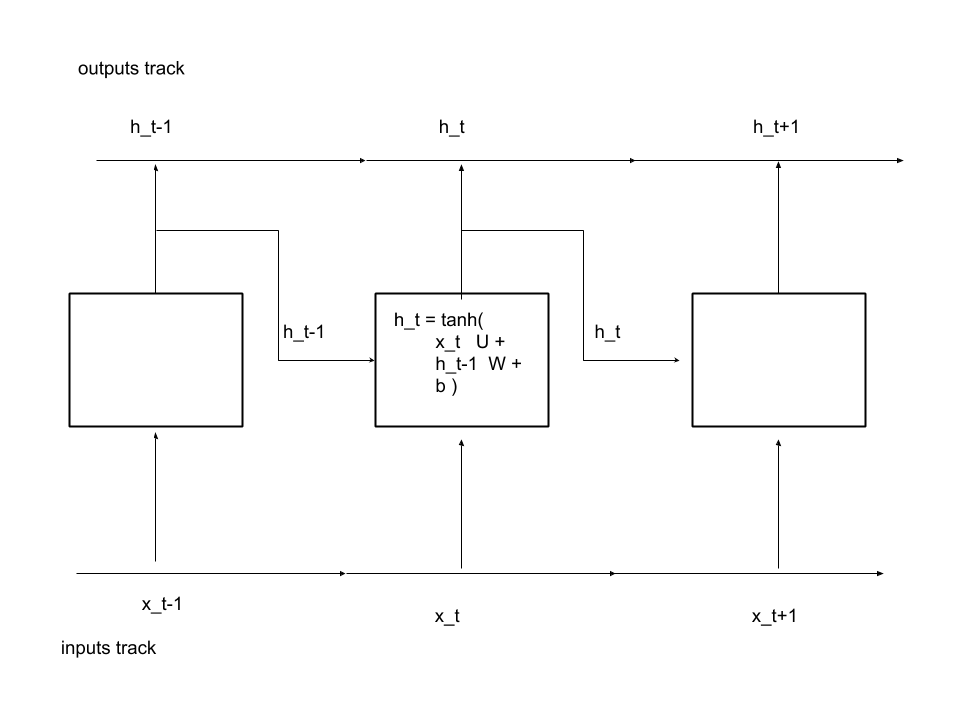

La formule est:
$$
   h_t= \tanh( x_t U + h_{t-1} W + b )
$$
Où les matrices de paramètres  $U,W,b$ ne dépendent pas de $t$. Elles décrivent la transition "générique" d'un temps à l'autre.  Elles sont initialisées aléatoirement, puis améliorées lors de la phase d'apprentissage.

***NB:*** De la formule ci-dessus, on déduit que $h_t$ est fonction de tout le passé des entrées: $(x_t,x_{t-1},x_{t-2},...,x_0)$.


***Remarque:*** A chaque temps, la sortie $h_t$ est redirigée vers la cellule. Ainsi on peut  aussi avoir en tête le dessin suivant:

![simple_rnn](https://raw.githubusercontent.com/vincentvigon/public/main/signal2/img/recurrent.png)

### LSTM


Ce sont des cellules (=boites de neurone) conçues pour apprendre des informations contenue dans de longues séries temporelles (ex: des romans). Si l'on essayait de faire cela avec le simple-RNN, l'information se perdrait au fil des couches lors de la rétropopagation du gradient.


L'idée est de rajouter une piste $(C_t)$ qui transporte (carry) l'information sur le long terme. Cette piste nourrit les neurones à chaque temps, mais elle est aussi modifiée à chaque temps.


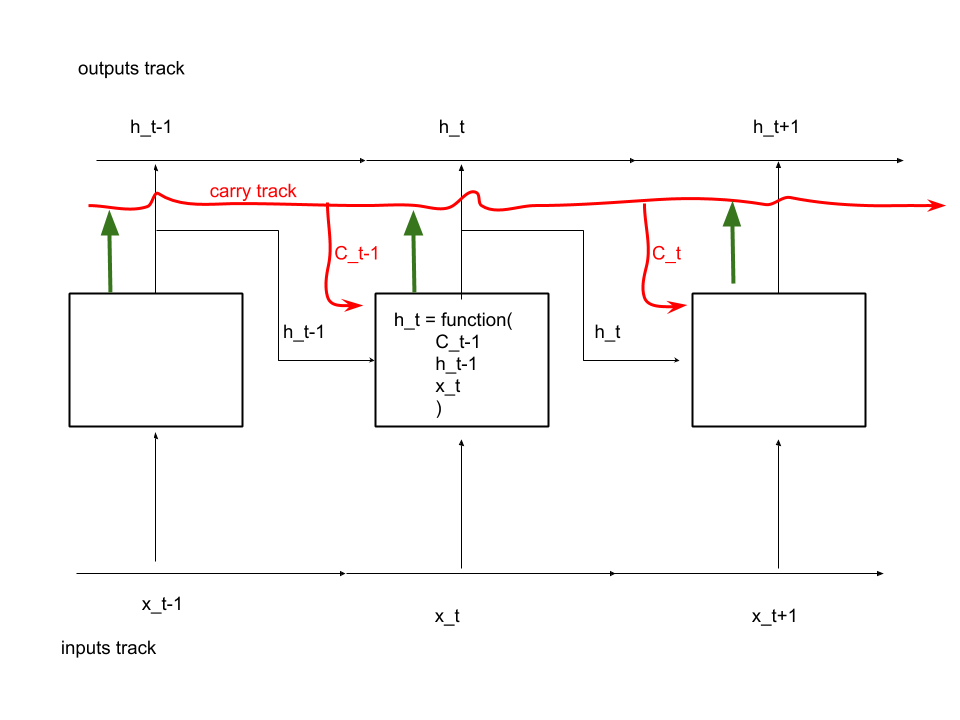

Mais voici le schéma complet:

![simple_rnn](https://raw.githubusercontent.com/vincentvigon/public/main/signal2/img/LSTM_GRU.png)


Considérons:

* $x_t$ l'entrée
* $h_{t-1}$ la sortie de l'instant précédent.
* $C_{t-1}$ le "Carry" précédent.

On calcule les nouvelles quantités $h_t,C_t$ par:

\begin{align*}
i_t &= \sigma(x_t U^i + h_{t-1} W^i +b^i)   \qquad \text{input gate} \\
f_t &= \sigma(x_t U^f + h_{t-1} W^f +b^f)   \qquad \text{forget gate} \\
o_t &= \sigma(x_t U^o + h_{t-1} W^o +b^o)   \qquad \text{output gate} \\
\\
\tilde C_t &=\tanh(x_t U+ h_{t-1}W + b )   \qquad \text{additional carry}  \\
C_t&= f_t * C_{t-1} + i_t*\tilde C_t  \qquad \text{updated carry} \\
\\
h_t&= o_t  * \tanh^?(C_t)   \qquad \text{output}
\end{align*}

Toutes les tenseurs $U^*,W^*,b^*$ ne dépendent pas de $t$. Elles sont initialisées aléatoirement, puis améliorer par l'apprentissage.

Les "gate" sont à valeur dans $[0,1]$. Elles sont mutlitpliées à d'autre quantités pour les laisser passer ou les anuler.


La fonction que l'on a noté $\tanh^?$ est la fonction d'activation finale. Comme la notation le suggère, la fonction la plus couremment utilisée est la tangente hyperbolique.



### GRU


![simple_rnn](https://raw.githubusercontent.com/vincentvigon/public/main/signal2/img/LSTM_GRU.png)


Considérons:

* $x_t$ l'entrée
* $h_{t-1}$ la sortie de l'instant précédent.

On calcule la nouvelle sortie $h_t$ par:
\begin{align*}
z_t &= \sigma(x_t U^z + h_{t-1} W^z +b^z)   \qquad \text{update gate} \\
r_t &= \sigma(x_t U^r + h_{t-1} W^r +b^r)   \qquad \text{reset gate} \\
\\
\tilde h_t &= \tanh(x_t U^h + r_t * h_{t-1} W^h + b ) \\
h_t &=(1-z_t)*h_{t-1} +z_t \tilde h_t
\end{align*}

Toutes les tenseurs $U^*,W^*,b^*$ ne dépendent pas de $t$. Elles sont initialisées aléatoirement, puis améliorées par l'apprentissage.



***A vous:*** $(2\heartsuit)$ Quelles valeurs doivent prendre les différentes "gates" pour que l'on retombe sur les `simpleRNN`?


### Codons un GRU

In [ ]:
in_size=19
hidden_size=2
gru_cell=eqx.nn.GRUCell(in_size, hidden_size, key=jr.key(0))
gru_cell

***A vous:*** A quoi correspondent les paramètres `weight_ih` et `weight_hh`. Pourquoi ont-ils ces shapes ?




In [ ]:
input=jnp.ones([in_size])
h=jnp.ones([hidden_size])
gru_cell(input,h)

### Ajoutons une couche dense

Puisque la sortie $h_t$ est réinjectée dans la cellule RNN, il est relativement important qu'elles soit de grande dimension pour avoir la capacité de conserver toutes les informations.  

Mais la vrai sortie $y_t$ a une dimension imposée par le problème.


C'est pour cela que l'on place toujours à la suite d'un layer RNN, un layer dense qui transforme le $h_t$ en une sortie apropriée $y_t$.



#### Exemple 1

Pour l'exemple 1: $x_t \in \mathbb R^7$ et $y_t$ est un vecteur de proba sur 3 classes (repos, marche, course). On calcule d'abors
$$
(h_t)= RNN[(x_t)]
$$
et l'on paramètre RNN pour que $h_t \in \mathbb R^{60}$. Puis:
$$
y_t = \mathtt{softmax}(h_t W + b)
$$
Avec $W$ une matrice $60\times 3$.

#### Exemple 2

Pour l'exemple 2: $x_t \in \mathbb R^{19}$ et $y_t$ est un vecteur de dimension 2 (températeur, pression). On calcul d'abors
$$
(h_t)= RNN[(x_t)]
$$
et l'on paramètre RNN pour que $h_t \in \mathbb R^{60}$. Puis:
$$
y_t = h_t W + b
$$
Avec $W$ une matrice $60\times 2$.

### Plus profond

Pour gagner en preformance, on enchaine généralement plusieurs couches de RNN. Cela donne:

$$
(h_t) = RNN_0[(x_t)]
$$
$$
(h'_t) = RNN_1[(h_t)]
$$
$$
(h''_t) = RNN_2[(h'_t)]
$$
Puis la sortie est calculée
$$
(y_t) = Dense[(h''_t), \text{activation}=\dots]
$$






## Implémentation

### La fonction `scan`

La fonction scan enchaine les étapes suivantes:


              output_0         output_1
                
                |                |
                |                |
    carry0 -step_fn--> carry1 -step_fn--> ...

                |                |
                |                |
               input_0         input_1

Implémentation à la main:

In [ ]:
def my_scan(step_fn, initial_carry, inputs):
    outputs=[]
    current_carry=initial_carry
    for input in inputs:
        current_carry,output = step_fn(current_carry,input)
        outputs.append(output)

    final_carry=current_carry
    return final_carry, jnp.stack(outputs)

In [ ]:
def step_fn_example(carry, input):
    new_carry = carry + input      # Mise à jour du carry
    output = new_carry**2          # Sortie à accumuler (la somme courante)
    return new_carry, output

In [ ]:
inputs = jnp.array([1., 2, 3, 4, 5])
initial_carry = 0.

In [ ]:
final_carry, outputs = my_scan(step_fn_example, initial_carry, inputs)
print(outputs)

Utilisons cette de jax

In [ ]:
final_carry, outputs = jax.lax.scan(step_fn_example, initial_carry, inputs)
print(outputs)

In [ ]:
jnp.sum(outputs)

Cette fonction est optimisée, et accepte les calculs de gradients forward ou backward. Par exemple:

In [ ]:
def fn_to_derive(x):
    _, outputs = jax.lax.scan(step_fn_example, x, inputs)
    return jnp.sum(outputs)

fn_to_derive(0.)

In [ ]:
jax.grad(fn_to_derive)(0.)

Pour calculer cette dériver jax a du effectuer une rétropropagation à traver toutes la chaine de scanage (donc une longue chaine si `len(inputs)` est grande).  

### Simple RNN

In [ ]:
sequence_len=10
dim_in=3
dim_h=5

#Les paramètres
U=jnp.ones([dim_in,dim_h])
W=jnp.ones([dim_h,dim_h])
b=jnp.ones([dim_h])
# Θ=(U,W,b), on le fait passer en paramètre global

In [ ]:
def step_of_h_x( h , x):
    new_h = jnp.tanh( x@U + h@W + b)
    y = new_h  # Sortie
    return new_h, y

In [ ]:
h=jnp.ones([dim_h])
x=jnp.ones([dim_in])
step_of_h_x(h,x)

Composons notre `rnn_step` avec la fonction `scan`:

In [ ]:
seq_len=24
h_init=jnp.ones([dim_h])
xs=jnp.ones([seq_len,dim_in])

h_final, ys = jax.lax.scan(step_of_h_x, h_init, xs)
h_final.shape, ys.shape

Et si l'on veut batcher:

In [ ]:
step_of_hV_xV=jax.vmap(step_of_h_x)


b=2 #batch_size
hV=jnp.ones([b,dim_h])
xV=jnp.ones([b,dim_in])

hV_,yV=step_of_hV_xV(hV,xV)
hV_.shape,yV.shape

In [ ]:
step_of_hV_xV=jax.vmap(step_of_h_x)

hV_init=jnp.ones([b,dim_h])
xVs=jnp.ones([seq_len,b,dim_in])

hV_final, yVs = jax.lax.scan(step_of_hV_xV, hV_init, xVs)
hV_final.shape, yVs.shape

Variante: on vmap après le scan.

In [ ]:
def scanned_steps_of_h_xs(h_init,xs):
    return jax.lax.scan(step_of_h_x, h_init, xs)

scanned_steps_of_hV_xsV=jax.vmap(scanned_steps_of_h_xs)

hV_init=jnp.ones([b,dim_h])
xsV=jnp.ones([b,seq_len,dim_in])

hV_final, ysV=scanned_steps_of_hV_xsV(hV_init,xsV)
hV_final.shape, ysV.shape

### Un modèle complet modifiant une séquence

Par exemple si on veut savoir à chaque instant la proba qu'on a de courir/marcher/être au repos.

In [ ]:
class RNN_modify_a_seq(eqx.Module):
    hidden_size: int
    cell: eqx.Module
    linear: eqx.nn.Linear

    def __init__(self, in_size, out_size, hidden_size, rkey):
        rkey1, rkey2 = jr.split(rkey)
        self.hidden_size = hidden_size
        self.cell = eqx.nn.GRUCell(in_size, hidden_size, key=rkey1)
        self.linear = eqx.nn.Linear(hidden_size, out_size, key=rkey2)


    def __call__(self, inputs):
        #(T,in_size)=inputs.shape

        h_init = jnp.zeros((self.hidden_size,)) #(hidden_size,)


        def f(carry, inp):
            h=self.cell(inp, carry)
            #return 2 fois h: le premier pour être utilisé par le prochain appelle de la cellule, le second pour être stocker dans les outputs
            return h, h

        h_final, outputs = lax.scan(f, h_init, inputs)
        #outputs.shape=(T,hidden_size)

        outputs=jax.vmap(self.linear)(outputs) #N'agit que sur le dernier axe, prenant l'axe du temps comme un axe de batch
        return outputs #(T,out_size)


seq_len=24 #mon temps de course en heure (balèze)
dim_in=7   #les 7 infos envoyées par ma montre connectées
dim_out=3  #3 logits, à transformer ensuite par un softmax pour obtenir les proba de courir/marcher/être au repos
dim_hidden=30
input=jnp.ones([seq_len,dim_in])
model=RNN_modify_a_seq(dim_in,dim_out,dim_hidden,jr.key(0))
model(input).shape

### Un modèle classifiant globalement la séquence

In [ ]:
class RNN_gives_a_proba_for_a_whole_sequence(eqx.Module):
    hidden_size: int
    cell: eqx.Module
    linear: eqx.nn.Linear

    def __init__(self, in_size, hidden_size, rkey):
        rkey1, rkey2 = jr.split(rkey)
        self.hidden_size = hidden_size
        self.cell = eqx.nn.GRUCell(in_size, hidden_size, key=rkey1)
        self.linear = eqx.nn.Linear(hidden_size, 1, key=rkey2)


    def __call__(self, input):

        h_init = jnp.zeros((self.hidden_size,))

        def f(carry, inp):
            h=self.cell(inp, carry)
            #On ne stocke rien dans l'output
            return h, None

        h_final, _ = lax.scan(f, h_init, input)

        return jax.nn.sigmoid(self.linear(h_final)) #renvoie une proba


seq_len=24 #mon temps de course en heure (balèze)
dim_in=7   #les 7 infos envoyées par ma montre connectées
dim_hidden=30
input=jnp.ones([seq_len,dim_in])
model=RNN_gives_a_proba_for_a_whole_sequence(dim_in,dim_hidden,jr.key(0))
model(input)

## Un problème jouet

C'est celui qui est proposé dans la doc d'equinox

### Création de Data

In [ ]:
def get_data(dataset_size, *, key):
    t = jnp.linspace(0, 2 * np.pi, 16)
    offset = jr.uniform(key, (dataset_size, 1), minval=0, maxval=2 * np.pi)
    x1 = jnp.sin(t + offset) / (1 + t)
    x2 = jnp.cos(t + offset) / (1 + t)
    y = jnp.ones((dataset_size, 1))

    half_dataset_size = dataset_size // 2
    x1 = x1.at[:half_dataset_size].multiply(-1)
    y = y.at[:half_dataset_size].set(0)
    x = jnp.stack([x1, x2], axis=-1)
    return x, y

In [ ]:
n_data=10
x,y=get_data(n_data,key=jr.key(0))
x.shape,y.shape

In [ ]:
fig,axs=plt.subplots(n_data,2,figsize=(8,6*b),sharex="all",sharey="all")
for i in range(n_data):
    axs[i,0].plot(x[i,:,0])
    axs[i,1].plot(x[i,:,1])
    axs[i,0].set_ylabel(f"label={int(y[i,0])}")

axs[0,0].set_title("feature 0")
axs[0,1].set_title("feature 1")

⇑ Présenté comme ci-dessus on a du mal à voir l'association entre les courbes et les label. Mais comme ci-dessous, l'humain comprend rapidement:

In [ ]:
fig,axs=plt.subplots(n_data,1,figsize=(4,4*n_data))
for i in range(n_data):
    axs[i].plot(x[i,:,0],x[i,:,1])
    axs[i].set_ylabel(f"label={int(y[i,0])}")

### Séparation en batch

In [ ]:
def dataloader(x,y, batch_size):
    dataset_size = x.shape[0]
    indices = np.arange(dataset_size)
    while True:
        perm = np.random.permutation(indices)
        start = 0
        end = batch_size
        while end <= dataset_size:
            batch_perm = perm[start:end]
            yield x[batch_perm],y[batch_perm]
            start = end
            end = start + batch_size

In [ ]:
batch_size=3
for x_batch,y_batch in  dataloader(x, y, batch_size):
    print(x_batch.shape,y_batch.shape)
    break

And finally the training loop.

In [ ]:
import optax

def main(
    dataset_size=10000,
    batch_size=32,
    learning_rate=3e-3,
    steps=200,
    hidden_size=16,
    depth=1,
    seed=5678,
):
    data_key, model_key = jr.split(jr.key(seed), 2)
    xs, ys = get_data(dataset_size, key=data_key)
    iter_data = dataloader(xs, ys, batch_size)

    model = RNN_gives_a_proba_for_a_whole_sequence(in_size=2, hidden_size=hidden_size, rkey=model_key)

    @eqx.filter_value_and_grad
    def compute_loss(model, x, y):
        pred_y = jax.vmap(model)(x)
        # Trains with respect to binary cross-entropy
        return -jnp.mean(y * jnp.log(pred_y) + (1 - y) * jnp.log(1 - pred_y))

    # Important for efficiency whenever you use JAX: wrap everything into a single JIT
    # region.
    @eqx.filter_jit
    def make_step(model, x, y, opt_state):
        loss, grads = compute_loss(model, x, y)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    optim = optax.adam(learning_rate)
    opt_state = optim.init(model)
    for step, (x, y) in zip(range(steps), iter_data):
        loss, model, opt_state = make_step(model, x, y, opt_state)
        loss = loss.item()
        print(f"step={step}, loss={loss}")

    pred_ys = jax.vmap(model)(xs)
    num_correct = jnp.sum((pred_ys > 0.5) == ys)
    final_accuracy = (num_correct / dataset_size).item()
    print(f"final_accuracy={final_accuracy}")

* `eqx.filter_value_and_grad` calcule les valeur de sortie du modèle, et les gradient associé à tous les paramètres.


* `eqx.filter_jit` regarde tous les arguments de `make_step`, et automatiquement fait un jit en prenant comme argument dynamique les tenseurs et statique tout le reste.

In [ ]:
main()